In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns
sns.set(style="dark")
sns.set_palette("Paired")
plt.rcParams.update({'font.size': 10})
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')
font_size = [13,14]

save_figs = False
# colors = sns.color_palette("Paired",12)
# color_idxs = [3,7,1] # steve, mve, ddpg
colors = sns.color_palette("tab10")
color_idxs = [2,1,-3] # steve, mve, ddpg
linestyle = ['solid','dashed','dashdot']

import matplotlib
mkfunc = lambda x, pos: '%1dM' % (x * 1e-6) if x >= 1e6 else '%1dk' % (x * 1e-3) if x >= 1e3 else '%1.1d' % x
mkformatter = matplotlib.ticker.FuncFormatter(mkfunc)

In [2]:
def reject_outliers_2(data, m=2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    print(d)
    print(mdev)
    print(mdev if mdev else 1.)
    s = d / (mdev if mdev else 1.)
    return data[s < m]

def pull_max(d):
    _rew = None
    new_mean = []
    for m in d:
        if _rew is None:
            _rew = m
        else:
            if m > _rew:
                _rew = m
        new_mean.append(_rew)
    return new_mean

def process_data(env_path, N=20 , skip_early_stop=False, penalize_early_stop=False, max_steps=1000, debug=False, reward_file = 'reward_data.pkl', csv=False):
    data = []
    min_size = np.inf
    for i,path in enumerate(glob.glob(env_path + 'seed*/')):
        try: 
            if csv: 
                data_set = np.genfromtxt(path + reward_file, delimiter=',')                
                xy_idx = [3,5]
            else:
                data_set = pickle.load(open(path + reward_file, 'rb'))
    #             print(data_set)
                data_set = np.stack(data_set)
                xy_idx = [0,1]
                if reward_file == 'eval_reward_data.pkl':
                    num_repeats = 10
                    frames = data_set[::num_repeats,xy_idx[0]][:-1,None]
                    means = np.mean(data_set[:-1,xy_idx[1]].reshape(-1, num_repeats), axis=1, keepdims=True)
                    data_set = np.concatenate([frames,means],axis=1)
            if data_set[-1,xy_idx[0]] < min_size:
                min_size = data_set[-1,xy_idx[0]]
            data.append(data_set)
            has_mode_insert_data = False
        except:
            pass
        
        
    interp_data,raw_data = [],[]
    if reward_file == 'eval_reward_data.pkl':
        x_samples = np.arange(10000,10000*len(frames)+1,10000)
        for data_set in data:
            _x, _y = data_set[:,xy_idx].T 
            interp_data.append(_y)
            raw_data.append(np.array([_x,_y]))
    else:
        x_samples = np.linspace(0, min_size, N)
        for data_set in data:
            _x, _y = data_set[:,xy_idx].T 
            _steps = np.roll(np.roll(data_set[:,xy_idx[0]],-1 ) - data_set[:,xy_idx[0]],1)
            _steps[0] = _x[0]
            if debug: 
                print(np.min(_steps),np.max(_steps))
            if skip_early_stop:
                data_idx = (_steps >= max_steps)
                _x, _y = _x[data_idx], _y[data_idx]
            elif penalize_early_stop:
                penalty = max_steps - _steps
                _y = _y + penalty
            interp_data.append(np.interp(x_samples, _x, _y))
            raw_data.append(np.array([_x,_y]))
        
    if debug: 
        print(len(interp_data))
        
    mean = np.mean(interp_data, axis=0)
    std  = np.std(interp_data, axis=0)
    data_log = {'x' : x_samples, 'mean' : mean, 'std' : std, 
                'max' : np.max(interp_data, axis=0),
               'min' : np.min(interp_data, axis=0),
               '-std' : mean-std,
               '+std' : mean+std, 'data' : interp_data, 'raw_data' : raw_data }
    
    return data_log

def plot_data(ax, log, label, color, linestyle="solid",marker="",raw=False,fill=True):
#     print(len(log['data']))
    ax.plot(log['x'], log['mean'], label=label, linestyle=linestyle, marker=marker, color=color)
    if not fill: 
        all_data = np.array(log['data']).T
        ax.plot(log['x'], all_data, alpha=0.3, linestyle=linestyle, marker=marker, color=color)
        if raw: 
            for data in log['raw_data']:
                ax.plot(data[0], data[1], alpha=0.3, linestyle=linestyle, marker=marker, color=color)    
        
    if fill:
        #     ax.fill_between(log['x'], 
        #                     log['min'], log['max'],
        #                     alpha=0.2)
        ax.fill_between(log['x'], 
                        log['-std'], log['+std'],
                        alpha=0.2, color=color)
    ax.tick_params(axis='both', which='major', labelsize=font_size[0])
    ax.xaxis.set_major_formatter(mkformatter)
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(log['x'][0][-1]/4))

def plot_interp_data(ax,x,y,label,linestyle,color,N=100): 
    x_des = np.linspace(0,np.max(x),N)
    data = np.interp(x_des,x,y)
    ax.plot(x_des,data,label=label,linestyle=linestyle,color=color)
    ax.tick_params(axis='both', which='major', labelsize=font_size[0])
    ax.xaxis.set_major_formatter(mkformatter)
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1e5/5))

In [3]:
# path = '../devel/H3/output_train_m22p12_modPretrain1k_modLR2/ddpg/Hopper-v2/seed_13/eval_reward_data.pkl'
# data_set = pickle.load(open(path, 'rb'))
# data_set = np.stack(data_set)
# xy_idx = [0,1]

# num_repeats = 10
# frames = data_set[::num_repeats,xy_idx[0]][:-1,None]
# means = np.mean(data_set[:-1,xy_idx[1]].reshape(-1, num_repeats), axis=1, keepdims=True)
# data_set = np.concatenate([frames,means],axis=1)
# data_set


# train vs master (H=3)

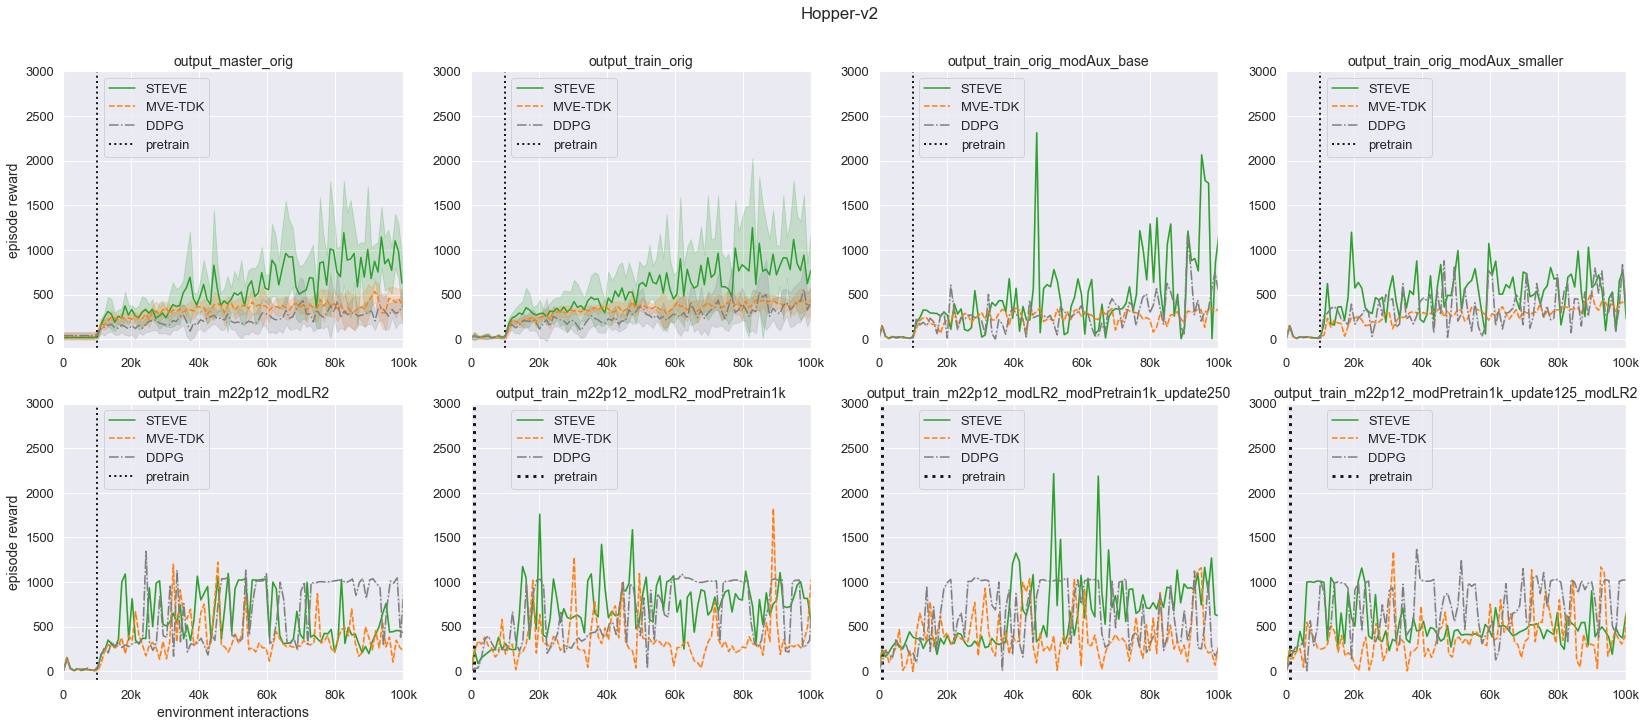

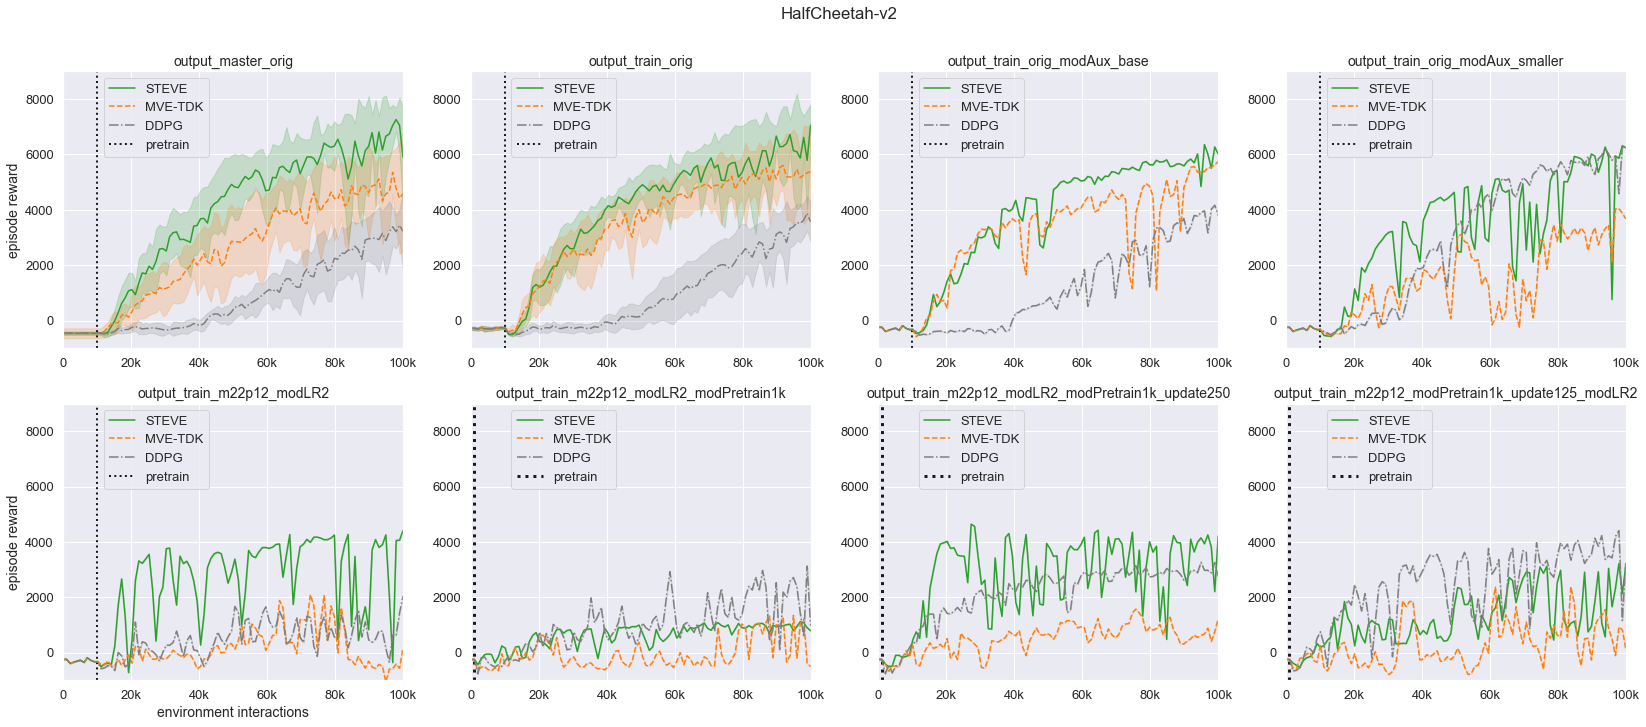

In [4]:
envs = ['Hopper-v2','HalfCheetah-v2']
ylim_mins = [-100,-1000]
ylim_maxes = [3000,9000]
save_names = ['hopper_comparisons.pdf','cheetah_comparisons.pdf']

methods = ['steve','mve_tdk','ddpg']
plot_legend = ['STEVE','MVE-TDK','DDPG']
plot_dirs = [['output_master_orig'],['output_train_orig'],
             ['output_train_orig_modAux_base'],
             ['output_train_orig_modAux_smaller'], 
#              ['output_train_orig_modAux_MNL2','output_train_orig_modAux_MNL6','output_train_orig_modAux_modRew',],
             ['output_train_m22p12_modLR2'],
             ['output_train_m22p12_modLR2_modPretrain1k'],
             ['output_train_m22p12_modLR2_modPretrain1k_update250'],
             ['output_train_m22p12_modPretrain1k_update125_modLR2'],
#              ['output_train_m12p12_modLR2_modPretrain1k'],
            ]

N = 100

fill = True
raw = True
skip_early_stop = False
penalize_early_stop = False

num_rows, num_cols, scale = 2,4,1.4

for env, save_name, ylim_min, ylim_max in zip(envs,save_names,ylim_mins,ylim_maxes):
    fig, axss = plt.subplots(num_rows, num_cols, figsize=(5*scale*num_cols,4*scale*num_rows))
    lgd_titles = [""]*num_cols*num_rows
    try: axs = [item for sublist in axss for item in sublist]
    except: axs = axss
    for method,lgd,ls,color_idx in zip(methods,plot_legend,linestyle,color_idxs):
        for idx,[ax, base_dirs] in enumerate(zip(axs,plot_dirs)):
            got_list = len(base_dirs) > 1 
            for dirs_idx, base_dir in enumerate(base_dirs): 
                if got_list:
                    if lgd == 'STEVE' :  c_idx = dirs_idx*2 + 2
                    if lgd == 'MVE-TDK': c_idx = dirs_idx*2 + 1
                    if lgd == 'DDPG' :   c_idx = dirs_idx*2 - 3
                    if idx in [5]:       lgd_dir = lgd + ' (' + base_dir.split('_')[-2] + ')'
                    else:                lgd_dir = base_dir.split('_')[-1]
                else: 
                    c_idx = color_idx
                    lgd_dir = lgd
                if idx == 0:   plot_method = 1 
#                 elif idx == 6: plot_method = 2
                else:          plot_method = 0
                try:
        #             print(env, method)
                    data_path = '../devel/H3/{}/{}/{}/'.format(base_dir,method, env)
                    log_path = 'log/{}.train.csv'.format(method)
                    if plot_method == 0:    data = process_data(data_path,skip_early_stop=skip_early_stop,penalize_early_stop=penalize_early_stop,N=N)
                    elif plot_method == 1:  data = process_data(data_path,skip_early_stop=skip_early_stop,penalize_early_stop=penalize_early_stop,N=N,reward_file=log_path,csv=True)
                    elif plot_method == 2:  data = process_data(data_path,skip_early_stop=skip_early_stop,penalize_early_stop=penalize_early_stop,reward_file='eval_reward_data.pkl')
                    if dirs_idx == 0:
                        if got_list:        lgd_titles[idx], title = lgd, '_'.join(base_dir.split('_')[:-1]) + "_<see legend>" # + '_' + base_dir.split('_')[-1]
                        else:               title = base_dir
#                         ax.set_title(title.split('/')[-1],fontsize=font_size[1])
                        ax.set_title(title,fontsize=font_size[1])
                    plot_data(ax,data,lgd_dir,linestyle=ls,color=colors[c_idx],fill=fill,raw=raw)
                except: 
                    pass

    axs[0].set_ylabel('episode reward', fontsize=font_size[1])
    axs[-num_cols].set_ylabel('episode reward', fontsize=font_size[1])
    axs[-num_cols].set_xlabel('environment interactions', fontsize=font_size[1])
    for i,[ax,lgd,dirs] in enumerate(zip(axs,lgd_titles,plot_dirs)): 
        ax.grid()
        ax.set_xlim([0,100000])
        ax.set_ylim([ylim_min,ylim_max])
        kwargs = {'title_fontsize': font_size[0], 'fontsize': font_size[0],'loc': 2, 'bbox_to_anchor': (0.1, 0., 1., 1.)}
    
        base_dirs, lgd = [], 'DDPG'
#         if i == 9:        base_dirs.append(['output_train_p12_modPretrain1k_modLR2',colors[color_idxs[-1]]])
        if i > 4:  ax.vlines(1000,ylim_min,ylim_max,label='pretrain',linestyle='dotted',linewidth=3)
        else:             ax.vlines(10000,ylim_min,ylim_max,label='pretrain',linestyle='dotted',linewidth=2)
#         if i == 6:        kwargs['title'] = r'$\bf{}\bf$'.format('eval')
        for [base_dir,c_idx] in base_dirs: 
            if i == 5:   lgd_dir = lgd + ' (' + base_dir.split('_')[-1] + ')'
            else:        lgd_dir = lgd
            try:
                data_path = '../devel/ddpg_only/{}/{}/{}/'.format(base_dir,'ddpg', env)
                data = process_data(data_path,skip_early_stop=skip_early_stop,penalize_early_stop=penalize_early_stop,N=N)
                plot_data(ax,data,lgd_dir,linestyle=ls,color=c_idx,fill=fill,raw=raw)
            except: 
                pass
        ax.legend(**kwargs)
    plt.suptitle(env,fontsize=font_size[1]*1.2,y=0.96,x=0.51)
        
    if save_figs:
        plt.savefig(save_name, bbox_inches='tight')

# train vs master (modified horizon)

No handles with labels found to put in legend.


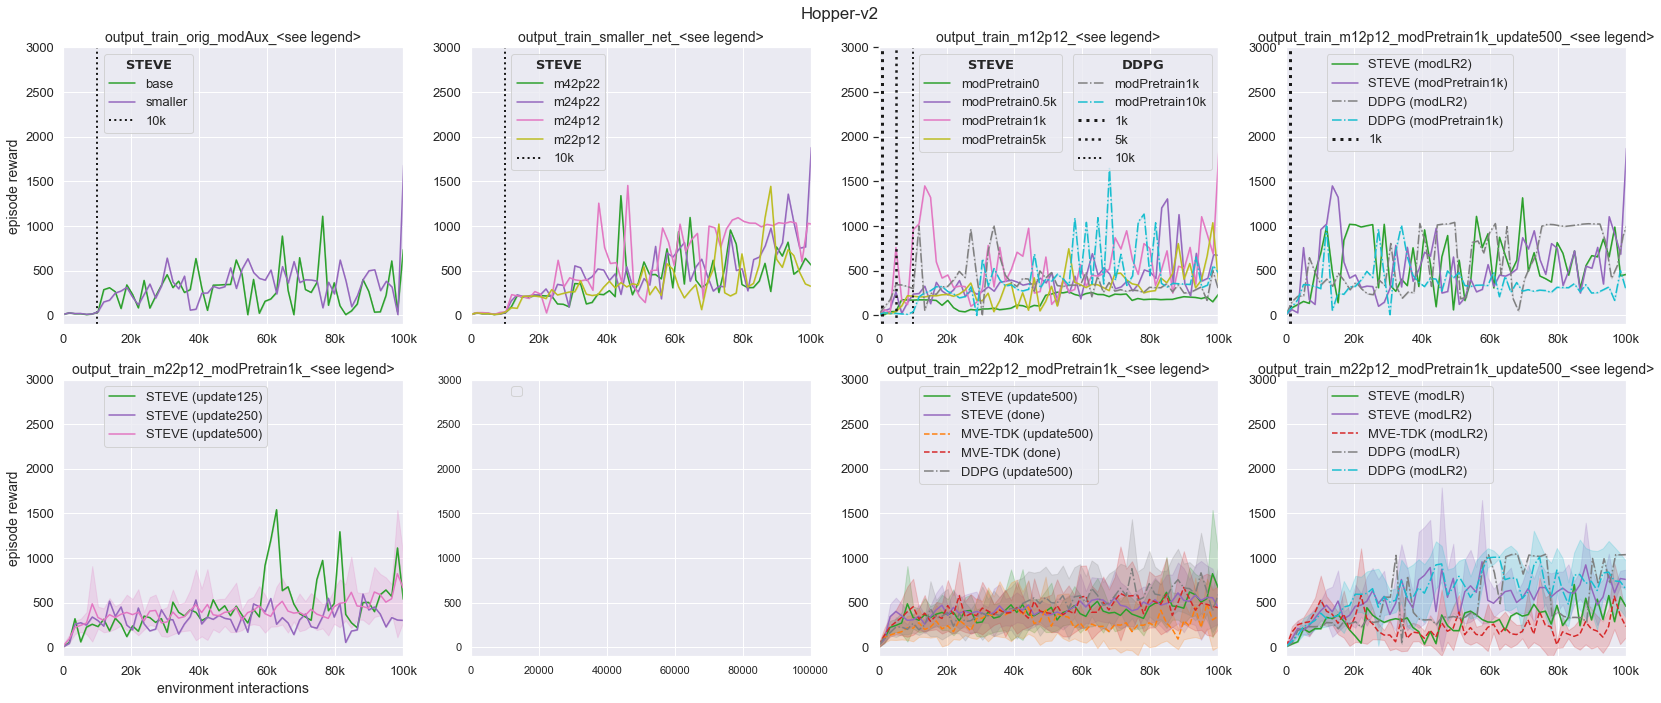

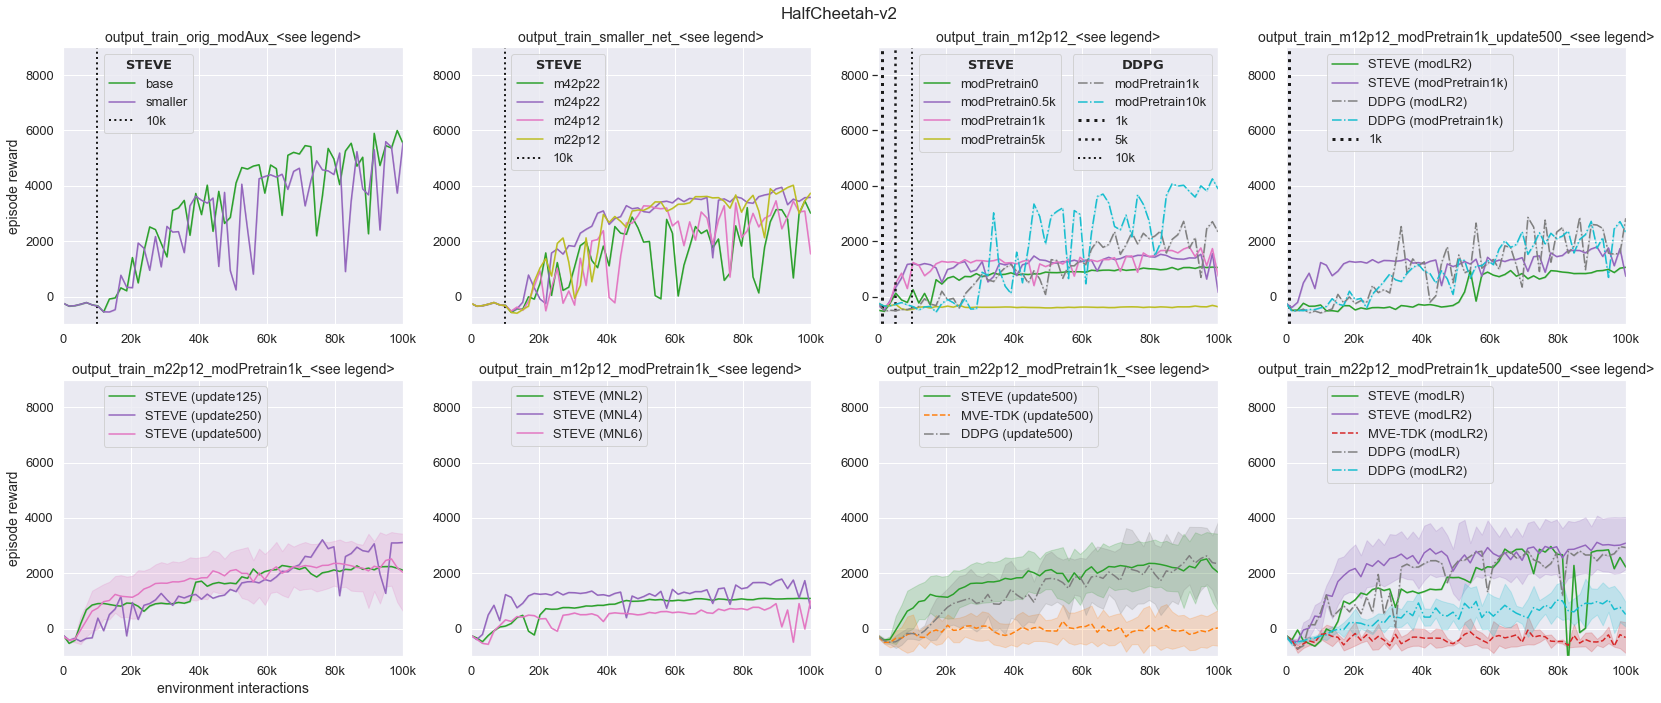

In [5]:
envs = ['Hopper-v2','HalfCheetah-v2']
ylim_mins = [-100,-1000]
ylim_maxes = [3000,9000]
save_names = ['hopper_comparisons.pdf','cheetah_comparisons.pdf']

methods = ['steve','mve_tdk','ddpg']
plot_legend = ['STEVE','MVE-TDK','DDPG']
plot_dirs = [['output_train_orig_modAux_base', 'output_train_orig_modAux_smaller',], 
             ['output_train_smaller_net_m42p22','output_train_smaller_net_m24p22','output_train_smaller_net_m24p12',
              'output_train_smaller_net_m22p12','output_train_smaller_net_m12p12',],
             ['m12p12/output_train_m12p12_modPretrain0','m12p12/output_train_m12p12_modPretrain0.5k','m12p12/output_train_m12p12_modPretrain1k',
              'm12p12/output_train_m12p12_modPretrain5k','m12p12/output_train_m12p12_modPretrain10k',],
             ['m12p12/output_train_m12p12_modPretrain1k_update500_modLR2','m12p12/output_train_m12p12_modPretrain1k'],
             ['m22p12/output_train_m22p12_modPretrain1k_update125','m22p12/output_train_m22p12_modPretrain1k_update250','m22p12/output_train_m22p12_modPretrain1k_update500'],
             ['m12p12/output_train_m12p12_modPretrain1k_MNL2','m12p12/output_train_m12p12_modPretrain1k_MNL4','m12p12/output_train_m12p12_modPretrain1k_MNL6'],
             ['m22p12/output_train_m22p12_modPretrain1k_update500','m22p12/output_train_m22p12_modPretrain1k_update500_done'],
             ['m22p12/output_train_m22p12_modPretrain1k_update500_modLR',
              'm22p12/output_train_m22p12_modPretrain1k_update500_modLR2'],
            ]

N = 60

fill = True
raw = True
skip_early_stop = False
penalize_early_stop = False

num_rows, num_cols, scale = 2,4,1.4

for env, save_name, ylim_min, ylim_max in zip(envs,save_names,ylim_mins,ylim_maxes):
    fig, axss = plt.subplots(num_rows, num_cols, figsize=(5*scale*num_cols,4*scale*num_rows))
    lgd_titles = [""]*num_cols*num_rows
    try: axs = [item for sublist in axss for item in sublist]
    except: axs = axss
    for method,lgd,ls,color_idx in zip(methods,plot_legend,linestyle,color_idxs):
        for idx,[ax, base_dirs] in enumerate(zip(axs,plot_dirs)):
            got_list = len(base_dirs) > 1 
            for dirs_idx, base_dir in enumerate(base_dirs): 
                if got_list:
                    if lgd != 'STEVE' and idx == 4: break
                    if lgd == 'STEVE' :  c_idx = dirs_idx*2 + 2
                    if lgd == 'MVE-TDK': c_idx = dirs_idx*2 + 1
                    if lgd == 'DDPG' :   c_idx = dirs_idx*2 - 3
                    if idx >2:    lgd_dir = lgd + ' (' + base_dir.split('_')[-1] + ')'
                    else:         lgd_dir = base_dir.split('_')[-1]
                else: 
                    c_idx = color_idx
                    lgd_dir = lgd
#                 if idx == 0: plot_method = 1 
#                 else: plot_method = 0
                plot_method = 0
                try:
        #             print(env, method)
                    data_path = '../devel/{}/{}/{}/'.format(base_dir,method, env)
                    log_path = 'log/{}.train.csv'.format(method)
                    if plot_method == 0:    data = process_data(data_path,skip_early_stop=skip_early_stop,penalize_early_stop=penalize_early_stop,N=N)
                    elif plot_method == 1:  data = process_data(data_path,skip_early_stop=skip_early_stop,penalize_early_stop=penalize_early_stop,N=N,reward_file=log_path,csv=True)
                    if dirs_idx == 0:
                        if got_list:        lgd_titles[idx], title = lgd, '_'.join(base_dir.split('_')[:-1]) + "_<see legend>"
                        else:               title = base_dir
                        ax.set_title(title.split('/')[-1],fontsize=font_size[1])
                    plot_data(ax,data,lgd_dir,linestyle=ls,color=colors[c_idx],fill=fill,raw=raw)
                except: 
                    pass

    axs[0].set_ylabel('episode reward', fontsize=font_size[1])
    axs[-num_cols].set_ylabel('episode reward', fontsize=font_size[1])
    axs[-num_cols].set_xlabel('environment interactions', fontsize=font_size[1])
    for i,[ax,lgd,dirs] in enumerate(zip(axs,lgd_titles,plot_dirs)): 
        ax.grid()
        ax.set_xlim([0,100000])
        ax.set_ylim([ylim_min,ylim_max])
        if i in [0,1]: ax.vlines(10000,ylim_min,ylim_max,label='10k',linestyle='dotted',linewidth=2)
        # main legend
        kwargs = {'title_fontsize': font_size[0], 'fontsize': font_size[0],'loc': 2, 'bbox_to_anchor': (0.1, 0., 1., 1.)}
        if i in [0,1,2]: kwargs['title'] = r'$\bf{}\bf$'.format(lgd)
        ax.legend(**kwargs)
    
        if i in [2,3]: ## ddpg p12_modPretrain1k / 10k
            base_dirs, lgd = [], 'DDPG'
            if i == 2: # create second legend
                ax = ax.twinx()
                kwargs['title'] = r'$\bf{}\bf$'.format(lgd)
                kwargs['loc'] = 1
                kwargs['bbox_to_anchor'] = (0., 0., 1., 1.)
                ax.set_xlim([0,100000])
                ax.set_ylim([ylim_min,ylim_max])
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                ax.vlines(1000,ylim_min,ylim_max,label='1k',linestyle='dotted',linewidth=3)
                ax.vlines(5000,ylim_min,ylim_max,label='5k',linestyle='dotted',linewidth=2.5)
                ax.vlines(10000,ylim_min,ylim_max,label='10k',linestyle='dotted',linewidth=2)
            else: 
                ax.vlines(1000,ylim_min,ylim_max,label='1k',linestyle='dotted',linewidth=3)
            if i == 2:      
                base_dirs.append(['output_train_p12_modPretrain1k',colors[7]])
                base_dirs.append(['output_train_p12_modPretrain10k',colors[9]])
            else: 
                base_dirs.append(['output_train_p12_modPretrain1k',colors[9]])
            for [base_dir,c_idx] in base_dirs: 
                if i == 2:   lgd_dir = base_dir.split('_')[-1]
                elif i == 3: lgd_dir = lgd + ' (' + base_dir.split('_')[-1] + ')'
                else:        lgd_dir = lgd
                try:
                    data_path = '../devel/ddpg_only/{}/{}/{}/'.format(base_dir,'ddpg', env)
                    data = process_data(data_path,skip_early_stop=skip_early_stop,penalize_early_stop=penalize_early_stop,N=N)
                    plot_data(ax,data,lgd_dir,linestyle=ls,color=c_idx,fill=fill,raw=raw)
                except: 
                    pass
            ax.legend(**kwargs)
    plt.suptitle(env,fontsize=font_size[1]*1.2,y=0.93,x=0.51)
        
    if save_figs:
        plt.savefig(save_name, bbox_inches='tight')